In [1]:
from google.colab import files

uploaded = files.upload()


Saving journal_final_reddit.xlsx to journal_final_reddit.xlsx


In [2]:
import pandas as pd


df = pd.read_excel('journal_final_reddit.xlsx')

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df.head())


                                                 URL  \
0  https://www.reddit.com/r/LoveIslandTV/comments...   
1  https://www.reddit.com/r/LoveIslandTV/comments...   
2  https://www.reddit.com/r/LoveIslandTV/comments...   
3  https://www.reddit.com/r/LoveIslandTV/comments...   
4  https://www.reddit.com/r/LoveIslandTV/comments...   

                                               Title  \
0  S10E15 (Monday 19th June) - "There's trouble f...   
1  S10E15 (Monday 19th June) - "There's trouble f...   
2  S10E15 (Monday 19th June) - "There's trouble f...   
3  S10E15 (Monday 19th June) - "There's trouble f...   
4  S10E15 (Monday 19th June) - "There's trouble f...   

                                                Body  Upvotes     Subreddit  \
0  # Episode synopsis:\n\n There's trouble in par...       56  LoveIslandTV   
1  # Episode synopsis:\n\n There's trouble in par...       56  LoveIslandTV   
2  # Episode synopsis:\n\n There's trouble in par...       56  LoveIslandTV   
3  # Episo

In [3]:
!pip install spacy

In [4]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [6]:
import pandas as pd
import spacy

# Load SpaCy model for English
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    # Process text using spaCy
    doc = nlp(text)

    # Extract noun lemmas
    noun_lemmas = [token.lemma_ for token in doc if token.pos_ == 'NOUN']

    return ' '.join(noun_lemmas)

# Ensure all entries in 'Comment' are strings and handle missing values first
df['Comment'] = df['Comment'].astype(str).fillna('')

# Now apply your preprocessing function after cleaning
df['Preprocessed_Text'] = df['Comment'].apply(preprocess_text)


In [7]:
print(df.dtypes)


URL                  object
Title                object
Body                 object
Upvotes               int64
Subreddit            object
Comment              object
Preprocessed_Text    object
dtype: object


In [8]:
!pip install gensim



In [9]:
from gensim.models.phrases import Phrases, Phraser

# Tokenize the preprocessed texts
tokenized_texts = [text.split() for text in df['Preprocessed_Text']]

# Build models for bigrams and trigrams
bigram = Phrases(tokenized_texts, min_count=3, threshold=10)
trigram = Phrases(bigram[tokenized_texts], threshold=10)

# Construct Phraser objects
bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

# Function to form bigrams and trigrams in texts
def form_ngrams(text):
    return ' '.join(trigram_phraser[bigram_phraser[text.split()]])

# Apply the function to the DataFrame
df['Text_with_Ngrams'] = df['Preprocessed_Text'].apply(form_ngrams)


In [10]:
df.to_excel('situationships_preprocessed_data.xlsx', index=False)
from google.colab import files
files.download('situationships_preprocessed_data.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Topic Modelling

In [11]:
!pip install gensim

In [12]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

# Tokenize the texts
tokenized_texts = [text.split() for text in df['Text_with_Ngrams']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_texts)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]


In [13]:
# Number of topics
num_topics = 10  # based on the template paper

# Build LDA model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         per_word_topics=True)


In [14]:
import pandas as pd

descriptive_stats = df.describe()
print(descriptive_stats)



           Upvotes
count  8598.000000
mean    593.589788
std    1146.611778
min       0.000000
25%      51.000000
50%     152.000000
75%     496.000000
max    4437.000000


In [15]:

df['Comment_Length'] = df['Comment'].apply(lambda x: len(x.split()))
comment_length_stats = df['Comment_Length'].describe()
total_words = df['Comment_Length'].sum()
print("\nTotal Number of Words Across All Comments:", total_words)
print(comment_length_stats)



Total Number of Words Across All Comments: 443783
count    8598.000000
mean       51.614678
std        74.557695
min         1.000000
25%        11.000000
50%        27.000000
75%        64.000000
max      1320.000000
Name: Comment_Length, dtype: float64


In [16]:
from gensim.models import CoherenceModel


In [17]:
# Assuming df['Text_with_Ngrams'] is the column containing the text data you want to process:
documents = df['Text_with_Ngrams'].tolist()

# Proceed with preprocessing
import spacy

# Load SpaCy model for English
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(doc):
    # Assuming 'doc' is a raw string. If 'doc' is already a list, you might need to join it back to a string:
    # doc = ' '.join(doc)
    processed_doc = nlp(doc.lower())
    return [token.lemma_ for token in processed_doc if token.is_alpha and not token.is_stop]

# Now, use the defined documents variable
processed_texts = [preprocess_text(' '.join(doc)) if isinstance(doc, list) else preprocess_text(doc) for doc in documents]


In [18]:
# Proceed with your dictionary and corpus creation
from gensim import corpora, models

dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# LDA model creation and coherence calculation
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10, random_state=500)
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)
print('Coherence Score: {:.2f}'.format(coherence_lda))

Coherence Score: 0.5909854915221048
Coherence Score: 0.59


In [19]:
# Extract topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.108*"relationship" + 0.041*"term" + 0.040*"situationship" + 0.030*"word" + 0.027*"people" + 0.024*"partner" + 0.022*"flag" + 0.020*"situation" + 0.016*"time" + 0.015*"question"')
(1, '0.252*"situationship" + 0.035*"relationship" + 0.025*"title" + 0.016*"hell" + 0.014*"thing" + 0.010*"talk" + 0.010*"ick" + 0.009*"dinner" + 0.008*"rule" + 0.008*"fwb"')
(2, '0.063*"girl" + 0.049*"man" + 0.028*"hand" + 0.023*"love" + 0.017*"op" + 0.015*"year" + 0.015*"option" + 0.014*"bro" + 0.013*"fuck" + 0.013*"person"')
(3, '0.128*"woman" + 0.071*"man" + 0.021*"sex" + 0.021*"wife" + 0.020*"guy" + 0.019*"girl" + 0.018*"interest" + 0.013*"song" + 0.013*"body" + 0.012*"friend"')
(4, '0.095*"people" + 0.058*"life" + 0.053*"person" + 0.030*"thing" + 0.024*"way" + 0.022*"weight" + 0.021*"man" + 0.019*"reason" + 0.018*"partner" + 0.016*"love"')
(5, '0.061*"time" + 0.051*"relationship" + 0.042*"thing" + 0.038*"friend" + 0.038*"year" + 0.034*"month" + 0.025*"guy" + 0.021*"sex" + 0.019*"situationship" + 0.

Sentiment Analysis

In [20]:
!pip install transformers


In [21]:
from transformers import pipeline

# Load the pre-trained RoBERTa model for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
def analyze_sentiment(text):
    # Convert to string and truncate if too long
    text = str(text)[:512]  # Truncate to 512 characters
    result = sentiment_pipeline(text)
    return result[0] if result else {"label": "unknown", "score": None}


In [23]:
def apply_sentiment_analysis_in_batches(data, batch_size=100):  # Adjust batch size as needed
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_results = [analyze_sentiment(text) for text in batch]
        results.extend(batch_results)
    return results


In [24]:
def analyze_sentiment(text):
    # Convert to string and truncate if too long
    text = str(text)[:512]  # Truncate to 512 characters
    result = sentiment_pipeline(text)
    return result[0] if result else {"label": "unknown", "score": None}


In [25]:
def apply_sentiment_analysis_in_batches(data, batch_size=100):  # Adjust batch size as needed
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_results = [analyze_sentiment(text) for text in batch]
        results.extend(batch_results)
    return results


In [26]:
# Apply the batch processing function to the 'Preprocessed_Text' column
df['Sentiment_Result'] = apply_sentiment_analysis_in_batches(df['Preprocessed_Text'])


In [27]:
!pip install openpyxl
excel_file_path = "sentiment_analysis_results.xlsx"
df.to_excel(excel_file_path, index=False, engine='openpyxl')
from google.colab import files

files.download(excel_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

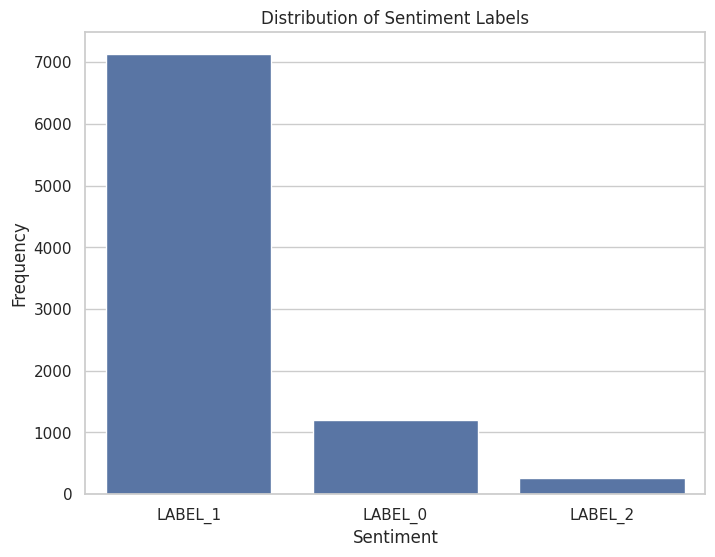

In [28]:
# Extract the sentiment labels
df['Sentiment_Label'] = df['Sentiment_Result'].apply(lambda x: x['label'] if isinstance(x, dict) and 'label' in x else 'unknown')

import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Sentiment_Label', order = df['Sentiment_Label'].value_counts().index)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


In [29]:
def extract_label(result):
    if isinstance(result, dict) and 'label' in result:
        return result['label']
    return 'unknown'

def extract_score(result):
    if isinstance(result, dict) and 'score' in result:
        return result['score']
    return None


In [30]:
df['Sentiment_Label'] = df['Sentiment_Result'].apply(extract_label)
df['Sentiment_Score'] = df['Sentiment_Result'].apply(extract_score)


In [31]:
# Display the first few rows to verify
df[['Comment', 'Sentiment_Label', 'Sentiment_Score']].head()


Comment Sentiment_Label  \
0    Sorted the thread to new, apologies about that!         LABEL_1   
1  mitch is isolating himself from the guys and b...         LABEL_1   
2  Can you imagine the damage Tyrique could do to...         LABEL_1   
3  “Tried to fly under the radar but I got caught...         LABEL_1   
4  Mitch gossiping with Whitney and Catherine is ...         LABEL_1   

   Sentiment_Score  
0         0.626437  
1         0.736228  
2         0.612825  
3         0.670516  
4         0.451272

In [32]:
# Display a few examples for each label
for label in df['Sentiment_Label'].unique():
    print(f"Examples for {label}:")
    examples = df[df['Sentiment_Label'] == label]['Comment'].head(5)
    print(examples.to_string(index=False), '\n')


Examples for LABEL_1:
   Sorted the thread to new, apologies about that!
mitch is isolating himself from the guys and be...
Can you imagine the damage Tyrique could do to ...
“Tried to fly under the radar but I got caught”...
Mitch gossiping with Whitney and Catherine is k... 

Examples for LABEL_0:
        "Why have you invited me here today" 😭😭😭😭😭
i’m really envious of Mitch’s self-confidence l...
I’m sorry but I love this version of Mitch. It’...
He was a french man in Mayfair just chilling, s...
Mitchell is genuinely threat to national securi... 

Examples for LABEL_2:
Medhi actually selected the simplest answer. Le...
Lol Whitney reactions to Mehdi is giving teenag...
I cannot wait for this evening’s latest install...
                           “It’s giving sexy” 💃🏾💃🏾
                              "It's giving sexy" 💃 



In [33]:
# Group by 'Sentiment_Label' and calculate statistics for 'Sentiment_Score'
grouped_data = df.groupby('Sentiment_Label')['Sentiment_Score'].describe()
print(grouped_data)


                  count      mean       std       min       25%       50%  \
Sentiment_Label                                                             
LABEL_0          1200.0  0.723512  0.153816  0.421291  0.581417  0.728126   
LABEL_1          7132.0  0.678344  0.141747  0.411178  0.557823  0.696932   
LABEL_2           266.0  0.699110  0.143300  0.447107  0.564037  0.694224   

                      75%       max  
Sentiment_Label                      
LABEL_0          0.865392  0.976671  
LABEL_1          0.802946  0.947604  
LABEL_2          0.813127  0.968749  


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


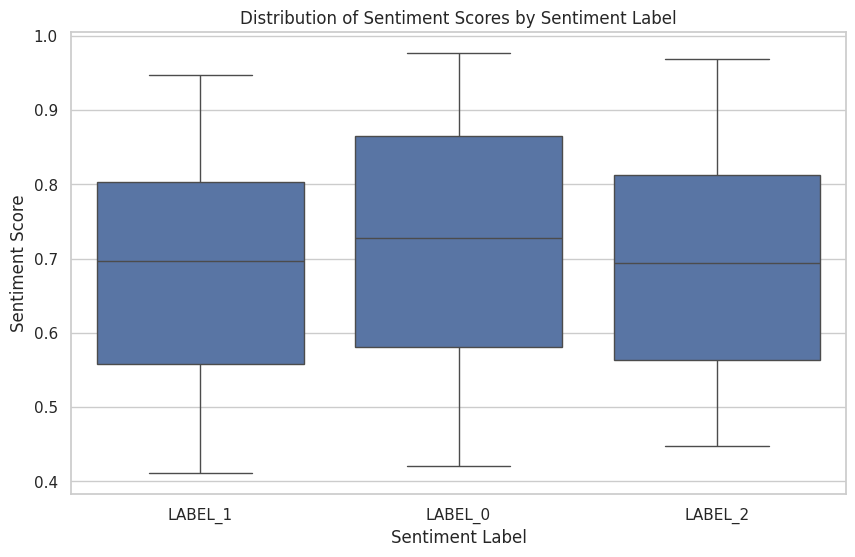

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment_Label', y='Sentiment_Score', data=df)
plt.title('Distribution of Sentiment Scores by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()


In [35]:
label_mapping = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}


In [36]:
# Assuming 'Sentiment_Label' is the column with labels like 'LABEL_0', 'LABEL_1', 'LABEL_2'
df['Sentiment_Label'] = df['Sentiment_Label'].map(label_mapping)


In [37]:
# Display the first few rows to check the updated labels
print(df[['Comment', 'Sentiment_Label']].head())


                                             Comment Sentiment_Label
0    Sorted the thread to new, apologies about that!         Neutral
1  mitch is isolating himself from the guys and b...         Neutral
2  Can you imagine the damage Tyrique could do to...         Neutral
3  “Tried to fly under the radar but I got caught...         Neutral
4  Mitch gossiping with Whitney and Catherine is ...         Neutral


In [38]:
sentiment_counts = df['Sentiment_Label'].value_counts(normalize=True) * 100
print(sentiment_counts)


Sentiment_Label
Neutral     82.949523
Negative    13.956734
Positive     3.093743
Name: proportion, dtype: float64


In [39]:
# Adjusting the threshold for high sentiment scores
lower_threshold = 0.7  # Example threshold, adjust as needed

high_negative_comments = df[(df['Sentiment_Label'] == 'Negative') & (df['Sentiment_Score'] > lower_threshold)]
high_positive_comments = df[(df['Sentiment_Label'] == 'Positive') & (df['Sentiment_Score'] > lower_threshold)]

# Check if we have filtered rows
print("High Negative Comments:", len(high_negative_comments))
print("High Positive Comments:", len(high_positive_comments))


High Negative Comments: 656
High Positive Comments: 130


In [40]:
# Count of each sentiment label
print(df['Sentiment_Label'].value_counts())


Sentiment_Label
Neutral     7132
Negative    1200
Positive     266
Name: count, dtype: int64


In [41]:
!pip install nltk
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize


In [45]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize and lower case
    words = word_tokenize(text.lower())
    # Remove punctuation and stop words
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return words

# Assuming df['Comment'] is a pandas DataFrame column
# Apply preprocessing to the comments
processed_words = preprocess_text(' '.join(df['Comment']))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [46]:
freq_dist = FreqDist(processed_words)
print(freq_dist.most_common(10))


[('like', 2396), ('relationship', 2013), ('want', 1799), ('time', 1545), ('someone', 1411), ('would', 1373), ('one', 1357), ('get', 1349), ('people', 1193), ('know', 1096)]


In [47]:
nltk.download('averaged_perceptron_tagger')

# Function to filter words by part of speech
def filter_pos(words, pos=['NN', 'NNS']):
    tagged = nltk.pos_tag(words)
    return [word for word, tag in tagged if tag in pos]

# Apply POS filtering
nouns = filter_pos(processed_words)
freq_dist_nouns = FreqDist(nouns)
print(freq_dist_nouns.most_common(10))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('relationship', 2013), ('time', 1545), ('someone', 1411), ('people', 1193), ('things', 788), ('person', 771), ('way', 737), ('life', 706), ('something', 701), ('years', 644)]


In [48]:
# Adjust the threshold as per your earlier analysis
threshold = 0.95  # Example threshold, can be adjusted

# Filter out highly negative comments
high_negative_comments = df[(df['Sentiment_Label'] == 'Negative') & (df['Sentiment_Score'] > threshold)]


In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')

# Start with the default NLTK stop words
stop_words = set(stopwords.words('english'))

# Add additional words to the stop words list
additional_stop_words = {"old", "put", "go", "u", "dude", "time" , "like", "get", "good", "want", "people", "need", "even", "tell", "make", "better", "life", "bc", "say","someone", "give", "love", "no", "know", "man", "women", "sounds", "one", "way", "wants", "think", "much", "would", "men", "person"}
stop_words.update(additional_stop_words)
# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Combine text of all high-negative comments
combined_text = ' '.join(high_negative_comments['Comment'])

# Preprocess the combined text
processed_words = preprocess_text(combined_text)

# Get frequency distribution
freq_dist = FreqDist(processed_words)

# Get top 10 words
top_10_negative_words = freq_dist.most_common(10)
for word, frequency in top_10_negative_words:
    print(f"{word}: {frequency}")


fuck: 31
shit: 24
situationship: 10
never: 8
respect: 7
piece: 7
ass: 7
bad: 6
asshole: 6
block: 5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# Adjust the threshold as per your earlier analysis
threshold = 0.9  # Example threshold, can be adjusted

# Filter out highly positive and neutral comments
high_positive_neutral_comments = df[((df['Sentiment_Label'] == 'Positive') | (df['Sentiment_Label'] == 'Neutral')) & (df['Sentiment_Score'] > threshold)]


In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add additional common words to the stop words list
additional_stop_words = { "sounds", "let", "sure", "back" ,"two", "think",'still', "grandparents", "years", "know", "year", "like", "get", "good", "would", "also", "really", "time", "date", "said", "one", "make", "even", "never", "go", "much", "say", "take", "going", "months", "long", "went", "way", "girl", "guy", "child", "rights"}  # Add more if needed
stop_words.update(additional_stop_words)

# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

# Combine text of all high-positive and neutral comments
combined_text = ' '.join(high_positive_neutral_comments['Comment'])

# Preprocess the combined text
processed_words = preprocess_text(combined_text)

# Get frequency distribution
freq_dist = FreqDist(processed_words)

# Get top 10 words
top_10_positive_neutral_words = freq_dist.most_common(10)
for word, frequency in top_10_positive_neutral_words:
    print(f"{word}: {frequency}")


relationship: 40
love: 30
want: 28
someone: 24
feel: 15
friends: 15
dating: 15
fwb: 14
family: 14
baby: 14


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
